## Setup + Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/AI Project/dataset.zip'

In [ ]:
!unzip -qo "{dataset_path}" -d "./dataset"

In [ ]:
# installing dependencies
!pip install -q "transformers[torch]==4.38.2" accelerate
!pip install -q datasets evaluate

# for augmentations
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
import os
from datasets import Dataset, load_dataset, DatasetDict
import evaluate
from transformers import Trainer, TrainingArguments
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import BeitImageProcessor, BeitForImageClassification
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import PIL.Image as Img
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import shutil
import albumentations as A
from uuid import uuid4

## Data Analysis

In [ ]:
#del data

In [ ]:
data = pd.read_csv('dataset/Training.csv')

In [ ]:
data.Image = data.Image.map(lambda x: f'dataset/Training Images/{x}')

In [ ]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,MildDemented
1,dataset/Training Images/mildDem1.jpg,MildDemented
2,dataset/Training Images/mildDem10.jpg,MildDemented
3,dataset/Training Images/mildDem100.jpg,MildDemented
4,dataset/Training Images/mildDem101.jpg,MildDemented
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,VeryMildDemented
5117,dataset/Training Images/verymildDem996.jpg,VeryMildDemented
5118,dataset/Training Images/verymildDem997.jpg,VeryMildDemented
5119,dataset/Training Images/verymildDem998.jpg,VeryMildDemented


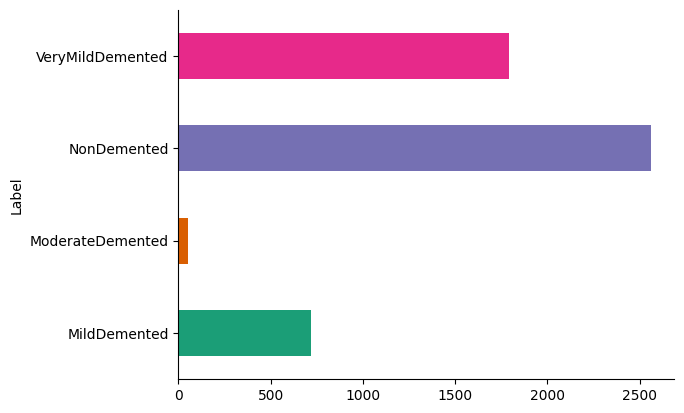

In [ ]:
# @title Label

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Image path: dataset/Training Images/mildDem324.jpg
Label: MildDemented
Image path: dataset/Training Images/nonDem1179.jpg
Label: NonDemented
Image path: dataset/Training Images/verymildDem1306.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/verymildDem839.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/nonDem408.jpg
Label: NonDemented
Image path: dataset/Training Images/verymildDem694.jpg
Label: VeryMildDemented


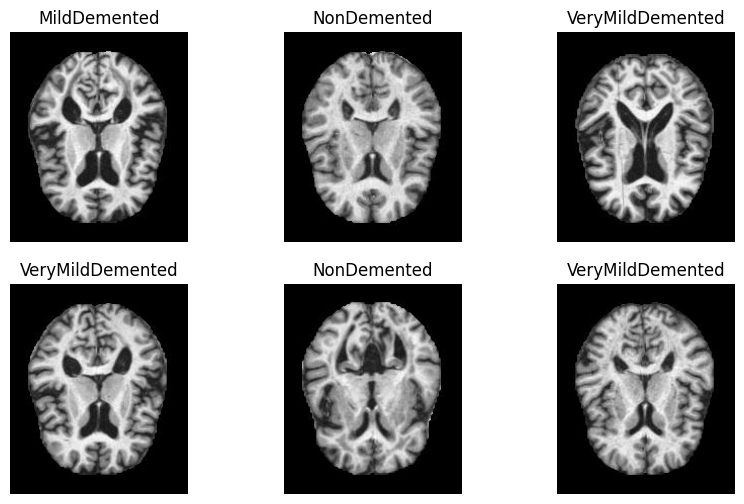

In [ ]:
plt.figure(figsize=(10, 6))

for i, idx in enumerate(np.random.choice(len(data), 6)):
    im_path = data.loc[idx, 'Image']  
    label = data.loc[idx, 'Label']    

    print("Image path:", im_path)
    print("Label:", label)

    img = cv2.imread(im_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

plt.show()

## Training Setup

In [ ]:
id2label = {str(i): c for i, c in enumerate(data.Label.unique())}
label2id = {c: str(i) for i, c in id2label.items()}

id2label

{'0': 'MildDemented',
 '1': 'ModerateDemented',
 '2': 'NonDemented',
 '3': 'VeryMildDemented'}

In [ ]:
data.Label = data.Label.map(lambda x: int(label2id[x]))

In [ ]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,0
1,dataset/Training Images/mildDem1.jpg,0
2,dataset/Training Images/mildDem10.jpg,0
3,dataset/Training Images/mildDem100.jpg,0
4,dataset/Training Images/mildDem101.jpg,0
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,3
5117,dataset/Training Images/verymildDem996.jpg,3
5118,dataset/Training Images/verymildDem997.jpg,3
5119,dataset/Training Images/verymildDem998.jpg,3


In [ ]:
image_counts = data['Label'].value_counts()
print(image_counts)

Label
2    2560
3    1792
0     717
1      52
Name: count, dtype: int64


In [ ]:
data_limited = pd.DataFrame()  
for label in [2]:
    data_subset = data[data['Label'] == label]
    
    data_subset_sampled = data_subset.sample(n=1800, random_state=42)
    data_limited = pd.concat([data_limited, data_subset_sampled])

data_other_labels = data[~data['Label'].isin([2])]
data_limited = pd.concat([data_limited, data_other_labels])

In [ ]:
data_limited

,Image,Label
2925,dataset/Training Images/nonDem635.jpg,2
2506,dataset/Training Images/nonDem258.jpg,2
1942,dataset/Training Images/nonDem2053.jpg,2
1247,dataset/Training Images/nonDem1428.jpg,2
2125,dataset/Training Images/nonDem2218.jpg,2
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,3
5117,dataset/Training Images/verymildDem996.jpg,3
5118,dataset/Training Images/verymildDem997.jpg,3
5119,dataset/Training Images/verymildDem998.jpg,3


In [ ]:
image_counts = data_limited['Label'].value_counts()
print(image_counts)

Label
2    1800
3    1792
0     717
1      52
Name: count, dtype: int64


In [ ]:
test = pd.DataFrame()
test = data
data = data_limited.reset_index(drop=True)


In [ ]:
image_counts = data['Label'].value_counts()
print(image_counts)

Label
2    1800
3    1792
0     717
1      52
Name: count, dtype: int64


In [ ]:
import albumentations as A
import cv2
import os
from torchvision import transforms as T
from torchvision.transforms import functional as F
from uuid import uuid4

initial_counts = {
    '2': 1800,  # NonDemented
    '3': 1792,  # VeryMildDemented
    '0': 717,   # MildDemented
    '1': 52     # ModerateDemented
}

target_count = 3000

def apply_augmentations(image):
    transform = A.Compose([
        A.RandomBrightnessContrast(p=1),
        A.Rotate(limit=(-180, 180), p=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomResizedCrop(height=image.shape[0], width=image.shape[1], p=0.5)
    ])
    return transform(image=image)['image']


!rm -rf augmented_dataset
for id in initial_counts.keys():
    os.makedirs(f'augmented_dataset/{id}', exist_ok=True)


for _, row in data.iterrows():
    img_path, label = row['Image'], row['Label']
    label = str(label)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image at {img_path}")
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_name = str(uuid4())
        cv2.imwrite(f'augmented_dataset/{label}/{img_name}_0.png', img)

        augmentations_needed = (target_count - initial_counts[label]) // initial_counts[label] + 1

        for i in range(augmentations_needed):
            augmented_img = apply_augmentations(img)
            cv2.imwrite(f'augmented_dataset/{label}/{img_name}_{i+1}.png', augmented_img)
            if len(os.listdir(f'augmented_dataset/{label}')) >= target_count:
                break


In [ ]:
import os

augmented_dataset_path = 'augmented_dataset'


image_counts = {}
for label in os.listdir(augmented_dataset_path):
    label_path = os.path.join(augmented_dataset_path, label)
    count = len(os.listdir(label_path))
    image_counts[label] = count

print("Number of images per class in the augmented dataset:")
for label, count in image_counts.items():
    print(f"Label {label}: {count} images")


Number of images per class in the augmented dataset:
Label 0: 3234 images
Label 2: 3600 images
Label 1: 3000 images
Label 3: 3584 images


In [ ]:
dataset = load_dataset('imagefolder', data_dir='augmented_dataset')['train'].train_test_split(0.2)
dataset

Resolving data files:   0%|          | 0/13418 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10734
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2684
    })
})

In [ ]:
#model_name = "google/vit-base-patch16-224-in21k"
model_name = "microsoft/beit-base-patch16-224-pt22k-ft22k"

In [ ]:
#processor = ViTImageProcessor.from_pretrained(model_name)
processor = BeitImageProcessor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# def transform(batch):
#   inputs = processor([Img.open(x).convert('RGB') for x in batch['Image']], return_tensors='pt', device=device)
#   inputs['label'] = batch['Label']

#   return inputs

def transform(batch):
  inputs = processor(batch['image'], return_tensors='pt')
  inputs['label'] = batch['label']

  return inputs

def collate(batch):
  return {
    'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
    'labels': torch.tensor([x['label'] for x in batch])
  }


accuracy = evaluate.load("accuracy")
def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from evaluate import load

f1_metric = load("f1")
accuracy_metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}


In [ ]:
prepared_dataset = dataset.with_transform(transform)

print(prepared_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10734
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2684
    })
})


In [ ]:
model = BeitForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)


config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'model = ViTForImageClassification.from_pretrained(\n      model_name,\n      num_labels=2,\n      id2label=id2label,\n      label2id=label2id,\n      ignore_mismatched_sizes=True\n    )'

In [ ]:
model.to(device)
print()

In [ ]:
training_args = TrainingArguments(
  output_dir="./vit_output",
  per_device_train_batch_size=32,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=10,
  fp16=True,
  logging_steps=12,
  learning_rate=1e-6,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

trainer = Trainer(
  model=model,
  args=training_args,
  data_collator=collate,
  compute_metrics=compute_metrics,
  train_dataset=prepared_dataset["train"],
  eval_dataset=prepared_dataset["test"],
  tokenizer=processor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.486900,0.397108,0.840909,0.840059
2,0.399300,0.383116,0.844262,0.843901
3,0.352000,0.389999,0.834948,0.833199
4,0.376700,0.375025,0.844635,0.843319
5,0.338300,0.372006,0.845380,0.844388
6,0.269600,0.367042,0.847988,0.847179
7,0.303000,0.366446,0.849478,0.848535
8,0.259600,0.366840,0.853204,0.852685
9,0.339600,0.366348,0.850596,0.849868
10,0.238400,0.366349,0.852086,0.851486


***** train metrics *****
  epoch                    =         10.0
  total_flos               = 7743559836GF
  train_loss               =       0.3334
  train_runtime            =   0:43:29.84
  train_samples_per_second =       41.129
  train_steps_per_second   =        1.287


In [ ]:
metrics = trainer.evaluate(prepared_dataset['test'])

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI Project/beit_v3_ckpt_10.pth')

## Inference on TestSet

In [ ]:
inf_model = BeitForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inf_model.to(device)
inf_model.load_state_dict(torch.load('/content/drive/MyDrive/AI Project/beit_v3_ckpt_10.pth'))

<All keys matched successfully>

## Newer Approach

In [ ]:
import os
import pandas as pd
import shutil
from uuid import uuid4
import glob
import cv2
from PIL import Image
from torchvision.transforms import functional as F


def create_and_copy_images(base_path, output_folder):
    if not os.path.exists(base_path):
        print(f"The specified base path does not exist: {base_path}")
        return

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_paths = glob.glob(os.path.join(base_path, '**', '*.jpg'), recursive=True)  
    images_data = []

    for img_path in image_paths:
        label = os.path.basename(os.path.dirname(img_path))
        unique_name = f"{uuid4()}.jpg"
        new_path = os.path.join(output_folder, unique_name)
        shutil.copy(img_path, new_path)
        images_data.append({'Image': new_path, 'Label': label})

    df = pd.DataFrame(images_data)
    df.to_csv('image_labels.csv', index=False)
    print(f"CSV created with {len(images_data)} entries in {output_folder}")


create_and_copy_images('dataset/Testing Images', 'dataset/Processed Images')

CSV created with 1279 entries in dataset/Processed Images


In [ ]:
testset = pd.read_csv('image_labels.csv')
predictions = {}

for index, row in testset.iterrows():
    img_path = row['Image']
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    inputs = processor(img, return_tensors='pt', device=device).to(device)

    logits = inf_model(**inputs).logits
    predicted_label = logits.argmax(-1).item()
    predictions[img_path] = id2label[str(predicted_label)]

predicted_df = pd.DataFrame(list(predictions.items()), columns=['Image', 'Predicted Label'])
predicted_df.to_csv('predictions_output2.csv', index=False)

In [ ]:
predictions_df = pd.read_csv('predictions_output2.csv')
results_df = pd.merge(testset, predictions_df, on='Image', how='left')
results_df['Actual ID'] = results_df['Label'].map(label2id)
results_df['Predicted ID'] = results_df['Predicted Label'].map(label2id)

accuracy = accuracy_score(results_df['Actual ID'], results_df['Predicted ID'])
f1 = f1_score(results_df['Actual ID'], results_df['Predicted ID'], average='weighted')
precision = precision_score(results_df['Actual ID'], results_df['Predicted ID'], average='weighted')
recall = recall_score(results_df['Actual ID'], results_df['Predicted ID'], average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.68
F1 Score: 0.66
Precision: 0.73
Recall: 0.68


## New approach to inference

In [ ]:
import os
import pandas as pd

def create_image_csv(base_path, output_csv):
    if not os.path.exists(base_path):
        print(f"The specified base path does not exist: {base_path}")
        return

    labels_folders = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    images_data = []

    for folder in labels_folders:
        folder_path = os.path.join(base_path, folder)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder, img_file) 
            images_data.append({'Image': img_path, 'Label': folder})


    df = pd.DataFrame(images_data)
    df.to_csv(output_csv, index=False)
    print(f"CSV created with {len(images_data)} entries.")

create_image_csv('dataset/Testing Images', 'testing_images.csv')


CSV created with 1279 entries.


In [ ]:
testset = pd.read_csv('testing_images.csv')
testset['Image'] = testset['Image'].map(lambda x: os.path.join('dataset/Testing Images', x))

testset.head()

,Image,Label
0,dataset/Testing Images/ModerateDemented/30 (2)...,ModerateDemented
1,dataset/Testing Images/ModerateDemented/30.jpg,ModerateDemented
2,dataset/Testing Images/ModerateDemented/28.jpg,ModerateDemented
3,dataset/Testing Images/ModerateDemented/27 (2)...,ModerateDemented
4,dataset/Testing Images/ModerateDemented/27.jpg,ModerateDemented


In [ ]:
pred = {}
for x in testset.Image:
  img = cv2.imread(x)
  inputs = processor([Img.open(x).convert('RGB')], return_tensors='pt', device=device).to(device)

  logits = inf_model(**inputs).logits
  predicted_label = logits.argmax(-1).item()

  pred[x] = id2label[str(predicted_label)]

In [ ]:
predicted_df = pd.DataFrame(list(pred.items()), columns=['Image', 'Predicted Label'])
predicted_df.to_csv('predictions_output.csv', index=False)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

predictions_df = pd.read_csv('predictions_output.csv')


In [ ]:
predictions_df

,Image,Predicted Label
0,dataset/Testing Images/ModerateDemented/30 (2)...,ModerateDemented
1,dataset/Testing Images/ModerateDemented/30.jpg,ModerateDemented
2,dataset/Testing Images/ModerateDemented/28.jpg,ModerateDemented
3,dataset/Testing Images/ModerateDemented/27 (2)...,ModerateDemented
4,dataset/Testing Images/ModerateDemented/27.jpg,ModerateDemented
...,...,...
1274,dataset/Testing Images/MildDemented/28 (12).jpg,VeryMildDemented
1275,dataset/Testing Images/MildDemented/28 (13).jpg,VeryMildDemented
1276,dataset/Testing Images/MildDemented/32.jpg,VeryMildDemented
1277,dataset/Testing Images/MildDemented/32 (28).jpg,NonDemented


In [ ]:
base_path = 'dataset/Testing Images'
labels_folders = os.listdir(base_path)

test_images = []
for folder in labels_folders:
    folder_path = os.path.join(base_path, folder)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        test_images.append((img_path, folder))

original_df = pd.DataFrame(test_images, columns=['Image', 'Label'])

In [ ]:
results_df = pd.merge(original_df, predictions_df, on='Image', how='left')

results_df.columns = ['Image', 'Actual Label', 'Predicted Label']

print(results_df)


                                                  Image      Actual Label  \
0     dataset/Testing Images/ModerateDemented/30 (2)...  ModerateDemented   
1        dataset/Testing Images/ModerateDemented/30.jpg  ModerateDemented   
2        dataset/Testing Images/ModerateDemented/28.jpg  ModerateDemented   
3     dataset/Testing Images/ModerateDemented/27 (2)...  ModerateDemented   
4        dataset/Testing Images/ModerateDemented/27.jpg  ModerateDemented   
...                                                 ...               ...   
1274    dataset/Testing Images/MildDemented/28 (12).jpg      MildDemented   
1275    dataset/Testing Images/MildDemented/28 (13).jpg      MildDemented   
1276         dataset/Testing Images/MildDemented/32.jpg      MildDemented   
1277    dataset/Testing Images/MildDemented/32 (28).jpg      MildDemented   
1278    dataset/Testing Images/MildDemented/32 (15).jpg      MildDemented   

       Predicted Label  
0     ModerateDemented  
1     ModerateDemented  


In [ ]:
results_df

,Image,Actual Label,Predicted Label
0,dataset/Testing Images/ModerateDemented/30 (2)...,ModerateDemented,ModerateDemented
1,dataset/Testing Images/ModerateDemented/30.jpg,ModerateDemented,ModerateDemented
2,dataset/Testing Images/ModerateDemented/28.jpg,ModerateDemented,ModerateDemented
3,dataset/Testing Images/ModerateDemented/27 (2)...,ModerateDemented,ModerateDemented
4,dataset/Testing Images/ModerateDemented/27.jpg,ModerateDemented,ModerateDemented
...,...,...,...
1274,dataset/Testing Images/MildDemented/28 (12).jpg,MildDemented,VeryMildDemented
1275,dataset/Testing Images/MildDemented/28 (13).jpg,MildDemented,VeryMildDemented
1276,dataset/Testing Images/MildDemented/32.jpg,MildDemented,VeryMildDemented
1277,dataset/Testing Images/MildDemented/32 (28).jpg,MildDemented,NonDemented


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label2id = {'MildDemented':0, 'ModerateDemented':1, 'NonDemented':2, 'VeryMildDemented':3}

results_df['Actual ID'] = results_df['Actual Label'].map(label2id)
results_df['Predicted ID'] = results_df['Predicted Label'].map(label2id)

accuracy = accuracy_score(results_df['Actual ID'], results_df['Predicted ID'])
f1 = f1_score(results_df['Actual ID'], results_df['Predicted ID'], average='weighted')  # weighted for imbalanced classes
precision = precision_score(results_df['Actual ID'], results_df['Predicted ID'], average='weighted')
recall = recall_score(results_df['Actual ID'], results_df['Predicted ID'], average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")



Accuracy: 0.66
F1 Score: 0.64
Precision: 0.72
Recall: 0.66


Confusion Matrix:
[[ 19   0  19 141]
 [  0  12   0   0]
 [  2   2 466 170]
 [  1   0  94 353]]


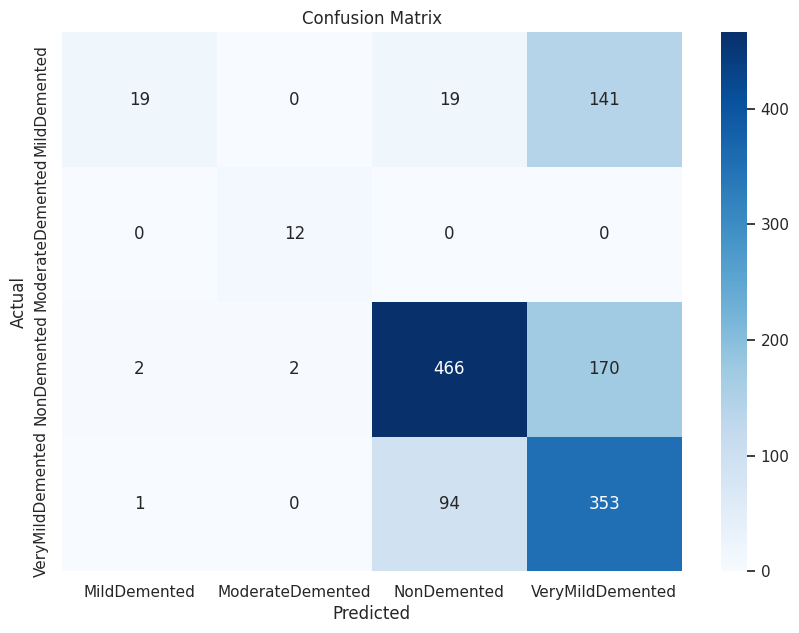

In [ ]:
cm = confusion_matrix(results_df['Actual ID'], results_df['Predicted ID'])
print("Confusion Matrix:")
print(cm)

sns.set()
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
results_df

,Image,Actual Label,Predicted Label,Actual ID,Predicted ID
0,dataset/Testing Images/ModerateDemented/30 (2)...,ModerateDemented,ModerateDemented,1,1
1,dataset/Testing Images/ModerateDemented/30.jpg,ModerateDemented,ModerateDemented,1,1
2,dataset/Testing Images/ModerateDemented/28.jpg,ModerateDemented,ModerateDemented,1,1
3,dataset/Testing Images/ModerateDemented/27 (2)...,ModerateDemented,ModerateDemented,1,1
4,dataset/Testing Images/ModerateDemented/27.jpg,ModerateDemented,ModerateDemented,1,1
...,...,...,...,...,...
1274,dataset/Testing Images/MildDemented/28 (12).jpg,MildDemented,VeryMildDemented,0,3
1275,dataset/Testing Images/MildDemented/28 (13).jpg,MildDemented,VeryMildDemented,0,3
1276,dataset/Testing Images/MildDemented/32.jpg,MildDemented,VeryMildDemented,0,3
1277,dataset/Testing Images/MildDemented/32 (28).jpg,MildDemented,NonDemented,0,2
